#### 1. 필요한 라이브러리 import 및 데이터 불러오기

In [1]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings  # 경고 메시지 무시
warnings.filterwarnings('ignore')

# 한글 폰트를 설정하여 시각화에 한글이 깨지지 않도록 설정
plt.rcParams['font.family'] = 'gulim'

In [3]:
file = pd.read_csv("C:/Users/Owner/Desktop/insurance_dataset.csv")
file.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46,male,21.45,5,yes,southeast,Diabetes,NaN,Never,Blue collar,Premium,20460.307669
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
2,38,male,44.88,2,yes,southwest,NaN,High blood pressure,Occasionally,Blue collar,Premium,20204.476302
3,25,male,19.89,0,no,northwest,NaN,Diabetes,Rarely,White collar,Standard,11789.029843
4,49,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838


In [4]:
data= pd.DataFrame(file)
data.head()
target = data['charges']

In [5]:
data.shape

(1000000, 12)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   age                     1000000 non-null  int64  
 1   gender                  1000000 non-null  object 
 2   bmi                     1000000 non-null  float64
 3   children                1000000 non-null  int64  
 4   smoker                  1000000 non-null  object 
 5   region                  1000000 non-null  object 
 6   medical_history         749238 non-null   object 
 7   family_medical_history  749596 non-null   object 
 8   exercise_frequency      1000000 non-null  object 
 9   occupation              1000000 non-null  object 
 10  coverage_level          1000000 non-null  object 
 11  charges                 1000000 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 91.6+ MB


In [7]:
data.describe()

,age,bmi,children,charges
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,41.495282,34.001839,2.499886,16735.117481
std,13.855189,9.231680,1.707679,4415.808211
min,18.000000,18.000000,0.000000,3445.011643
25%,29.000000,26.020000,1.000000,13600.372379
50%,41.000000,34.000000,2.000000,16622.127973
75%,53.000000,41.990000,4.000000,19781.465410
max,65.000000,50.000000,5.000000,32561.560374


### 2.결측치 처리 및 데이터 타입 변경

In [8]:
data.isnull().sum()

age                            0
gender                         0
bmi                            0
children                       0
smoker                         0
region                         0
medical_history           250762
family_medical_history    250404
exercise_frequency             0
occupation                     0
coverage_level                 0
charges                        0
dtype: int64

In [9]:
## 결측치는 아예 제거 하기로 하고 결측치가 제거된 데이터를 df변수에 담는다.
df = data.dropna()

In [10]:
## 결측치가 잘 제거됐는지 확인
df.isnull().sum()

age                       0
gender                    0
bmi                       0
children                  0
smoker                    0
region                    0
medical_history           0
family_medical_history    0
exercise_frequency        0
occupation                0
coverage_level            0
charges                   0
dtype: int64

In [11]:
## 문자형 변수는 추후 모델 성능을 위해 범주형 변수로 변환.
def convert_to_categorical(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('category')
    
    return df

def convert_to_float(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('float64')

    return df
df = convert_to_categorical(df)
df = convert_to_float(df)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 561672 entries, 1 to 999999
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   age                     561672 non-null  float64 
 1   gender                  561672 non-null  category
 2   bmi                     561672 non-null  float64 
 3   children                561672 non-null  float64 
 4   smoker                  561672 non-null  category
 5   region                  561672 non-null  category
 6   medical_history         561672 non-null  category
 7   family_medical_history  561672 non-null  category
 8   exercise_frequency      561672 non-null  category
 9   occupation              561672 non-null  category
 10  coverage_level          561672 non-null  category
 11  charges                 561672 non-null  float64 
dtypes: category(8), float64(4)
memory usage: 25.7 MB


#### 3.칼럼별 통계정보 확인

In [13]:
age = df[['age']]
age.describe()

,age
count,561672.000000
mean,41.492821
std,13.857684
min,18.000000
25%,29.000000
50%,41.000000
75%,53.000000
max,65.000000


In [14]:
gender = df['gender']
gender.value_counts()

gender
male      281056
female    280616
Name: count, dtype: int64

In [15]:
bmi = df['bmi']
bmi.describe()

count    561672.000000
mean         33.989205
std           9.235109
min          18.000000
25%          26.010000
50%          33.960000
75%          41.990000
max          50.000000
Name: bmi, dtype: float64

In [16]:
children = df['children']
children.describe()

count    561672.000000
mean          2.498723
std           1.708084
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max           5.000000
Name: children, dtype: float64

In [17]:
smoker = df['smoker']
smoker.value_counts()

smoker
yes    280993
no     280679
Name: count, dtype: int64

In [18]:
region = df['region']
region.value_counts()

region
northeast    140835
southwest    140469
southeast    140409
northwest    139959
Name: count, dtype: int64

In [19]:
medical_history = df['medical_history']
medical_history.value_counts()

medical_history
Heart disease          187846
Diabetes               186957
High blood pressure    186869
Name: count, dtype: int64

In [20]:
family_medical_history = df['family_medical_history']
family_medical_history.value_counts()

family_medical_history
Heart disease          187302
Diabetes               187224
High blood pressure    187146
Name: count, dtype: int64

In [21]:
exercise_frequency = df['exercise_frequency']
exercise_frequency.value_counts()

exercise_frequency
Occasionally    140615
Rarely          140567
Never           140285
Frequently      140205
Name: count, dtype: int64

In [22]:
occupation = df['occupation']
occupation.value_counts()

occupation
Unemployed      140880
Student         140626
Blue collar     140330
White collar    139836
Name: count, dtype: int64

In [23]:
coverage_level = df['coverage_level']
coverage_level.value_counts()

coverage_level
Standard    187704
Basic       187043
Premium     186925
Name: count, dtype: int64

In [24]:
medical_history = df['medical_history']
medical_history.value_counts()

medical_history
Heart disease          187846
Diabetes               186957
High blood pressure    186869
Name: count, dtype: int64

> 칼럼별 분포 확인을 위한 그래프 그리기

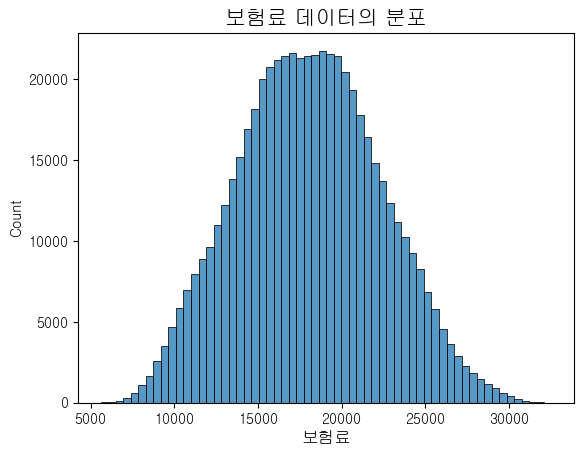

In [25]:
fig = sns.histplot(data=df, x='charges', bins=60)
plt.xlabel("보험료",fontsize=12)
plt.title("보험료 데이터의 분포",fontsize=15)
plt.show()

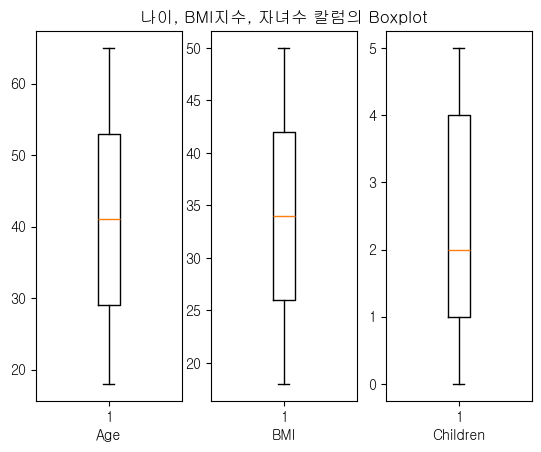

In [26]:
boxplot = plt.figure()

axes1 = boxplot.add_subplot(1, 3, 1)
axes1.boxplot(x = df['age'])
plt.xlabel('Age')


axes2 = boxplot.add_subplot(1, 3, 2)
axes2.boxplot(x = df['bmi'])
plt.xlabel('BMI')
plt.title("나이, BMI지수, 자녀수 칼럼의 Boxplot")

axes3 = boxplot.add_subplot(1, 3, 3)
axes3.boxplot(x= df['children'])
plt.xlabel('Children')


plt.show()


> 위 그래프를 통해 Age, BMI, Children 칼럼 모두 이상치 없음을 확인.  
Age : 데이터의 분포는 약 20에서 60 사이로 나타남. 중앙값은 약 40세.  
BMI : 데이터의 분포는 약 20에서 50사이로 나타남. 중앙값은 약 34로 보임.  
Children : 데이터의 분포는 0에서 5로 나타남. 중앙값은 2.  


#### 4. 필요없는 변수 제거 과정

<Axes: xlabel='연령대'>

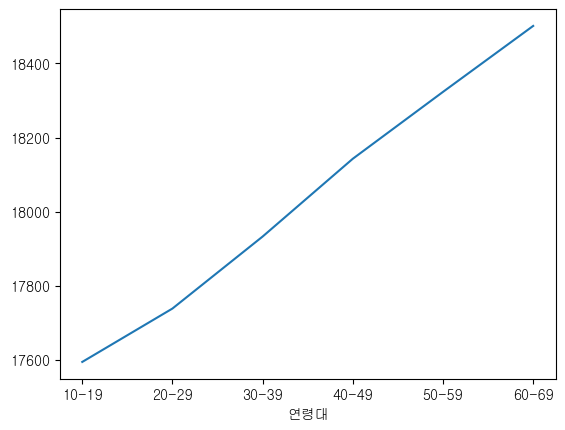

In [27]:
## age와 charges
df01 = df.copy()
df01["연령대"] = pd.cut(x = df['age'], bins = [0, 10, 20, 30, 40, 50, 60, 70, 80],
                           labels = ["0-9","10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70+"], right = False)
df01.groupby(['연령대'])['charges'].mean().plot.line()

<Axes: xlabel='gender'>

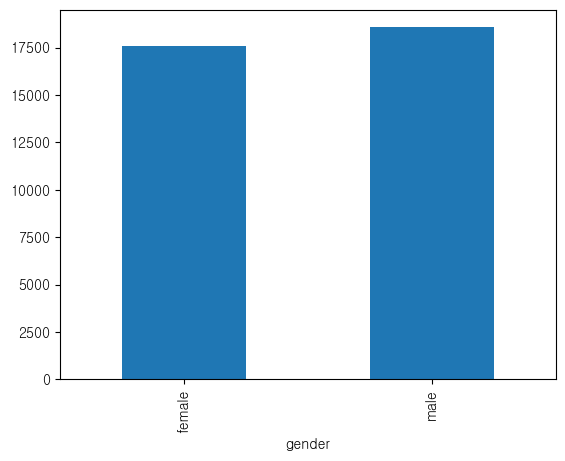

In [28]:
df.groupby(['gender'])['charges'].mean().plot.bar()

<Axes: xlabel='bmi'>

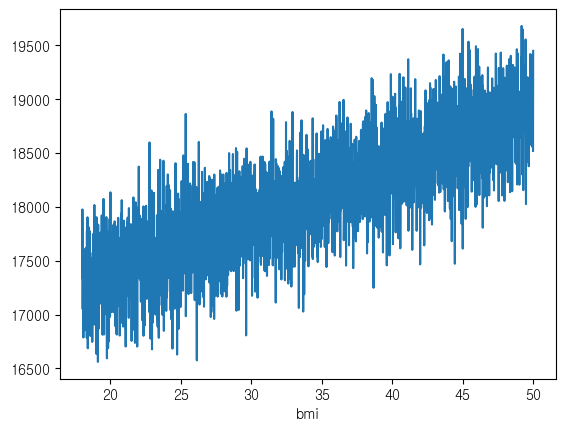

In [29]:
df.groupby(['bmi'])['charges'].mean().plot.line()


<Axes: xlabel='smoker'>

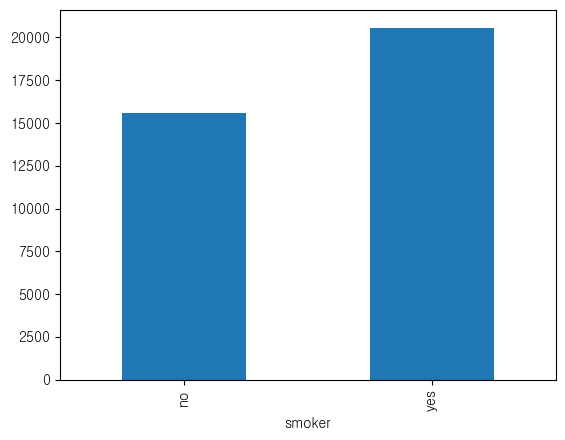

In [30]:
df.groupby(['smoker'])['charges'].mean().plot.bar()

<Axes: xlabel='region'>

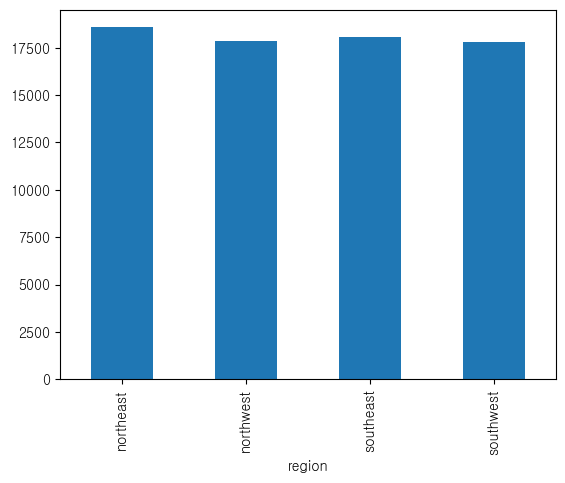

In [31]:
df.groupby(['region'])['charges'].mean().plot.bar()


<Axes: xlabel='medical_history'>

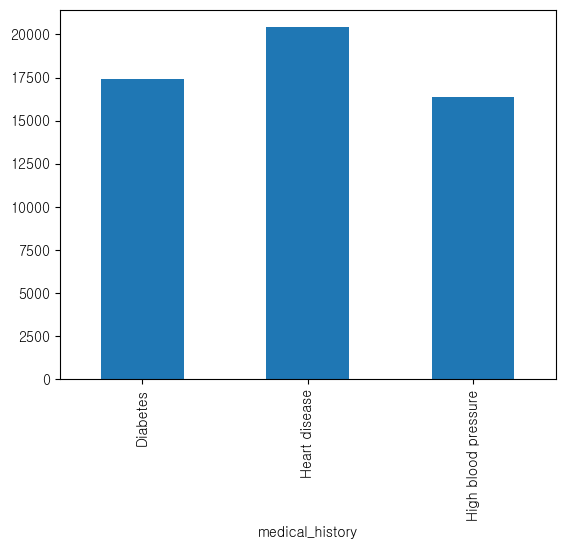

In [32]:
df.groupby(['medical_history'])['charges'].mean().plot.bar()

<Axes: xlabel='family_medical_history'>

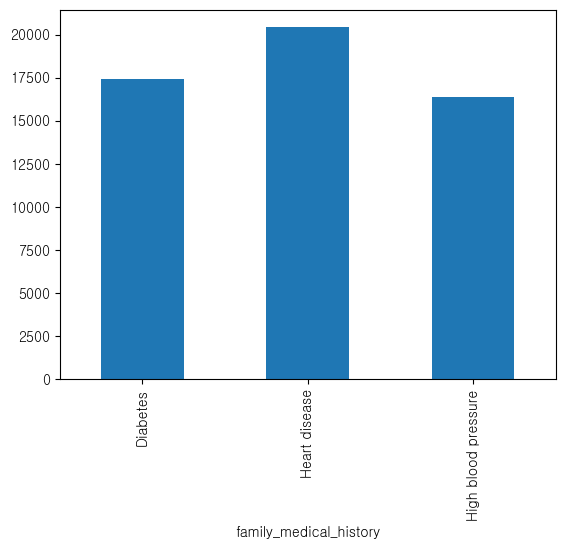

In [33]:
df.groupby(['family_medical_history'])['charges'].mean().plot.bar()

<Axes: xlabel='exercise_frequency'>

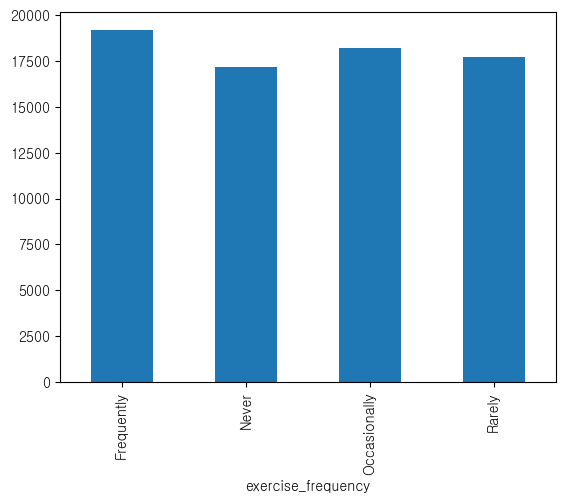

In [34]:
df.groupby(['exercise_frequency'])['charges'].mean().plot.bar()

<Axes: xlabel='occupation'>

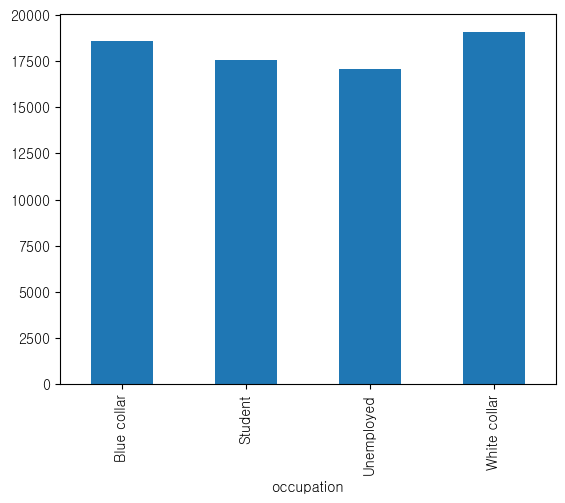

In [35]:
df.groupby(['occupation'])['charges'].mean().plot.bar()

<Axes: xlabel='coverage_level'>

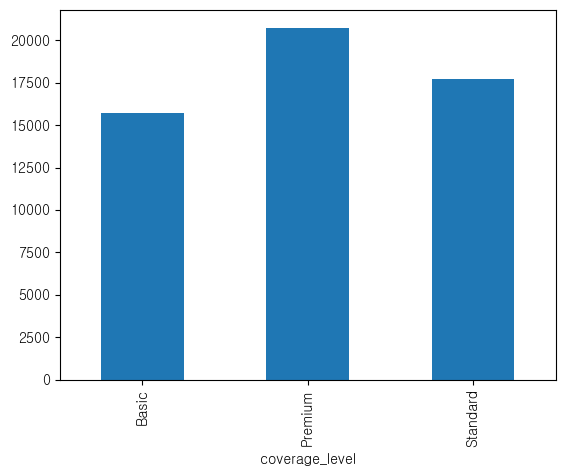

In [36]:
df.groupby(['coverage_level'])['charges'].mean().plot.bar()

> 위 그래프를 봤을 때  
나이가 많을수록, 흡연자일수록, bmi지수가 높을수록, 심장질병이 있을수록, 운동을 자주 할수록, 보험 적용 범위가 넓을수록 보험료가 높은 것을 확인할 수 있다.   
위의 경우에 비해 성별, 직업, 자녀수, 지역에 따른 보험료의 변화는 미미하다고 판단하여 제거하기로 결정. 

In [37]:
df = df.drop(columns=['gender', 'children', 'region', 'occupation'])

#### 5.범주형 데이터 인코딩

In [38]:

ct = make_column_transformer(
    (OneHotEncoder(sparse_output=False), [ 'smoker', 'medical_history', 'family_medical_history', 'exercise_frequency', 'coverage_level']),
    remainder='passthrough')
df = ct.fit_transform(df)
df = pd.DataFrame(df, columns=ct.get_feature_names_out())
df

,onehotencoder__smoker_no,onehotencoder__smoker_yes,onehotencoder__medical_history_Diabetes,onehotencoder__medical_history_Heart disease,onehotencoder__medical_history_High blood pressure,onehotencoder__family_medical_history_Diabetes,onehotencoder__family_medical_history_Heart disease,onehotencoder__family_medical_history_High blood pressure,onehotencoder__exercise_frequency_Frequently,onehotencoder__exercise_frequency_Never,onehotencoder__exercise_frequency_Occasionally,onehotencoder__exercise_frequency_Rarely,onehotencoder__coverage_level_Basic,onehotencoder__coverage_level_Premium,onehotencoder__coverage_level_Standard,remainder__age,remainder__bmi,remainder__charges
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,25.0,25.38,20390.899218
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,49.0,38.21,19268.309838
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,64.0,20.12,9563.655011
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,53.0,30.51,15845.293730
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,45.0,39.68,14892.145930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561667,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,49.0,32.51,22115.581098
561668,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,42.0,25.92,9705.965254
561669,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,39.0,39.84,22076.632856
561670,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,37.0,45.06,20297.618728



#### 6. 상관관계 분석

<Axes: >

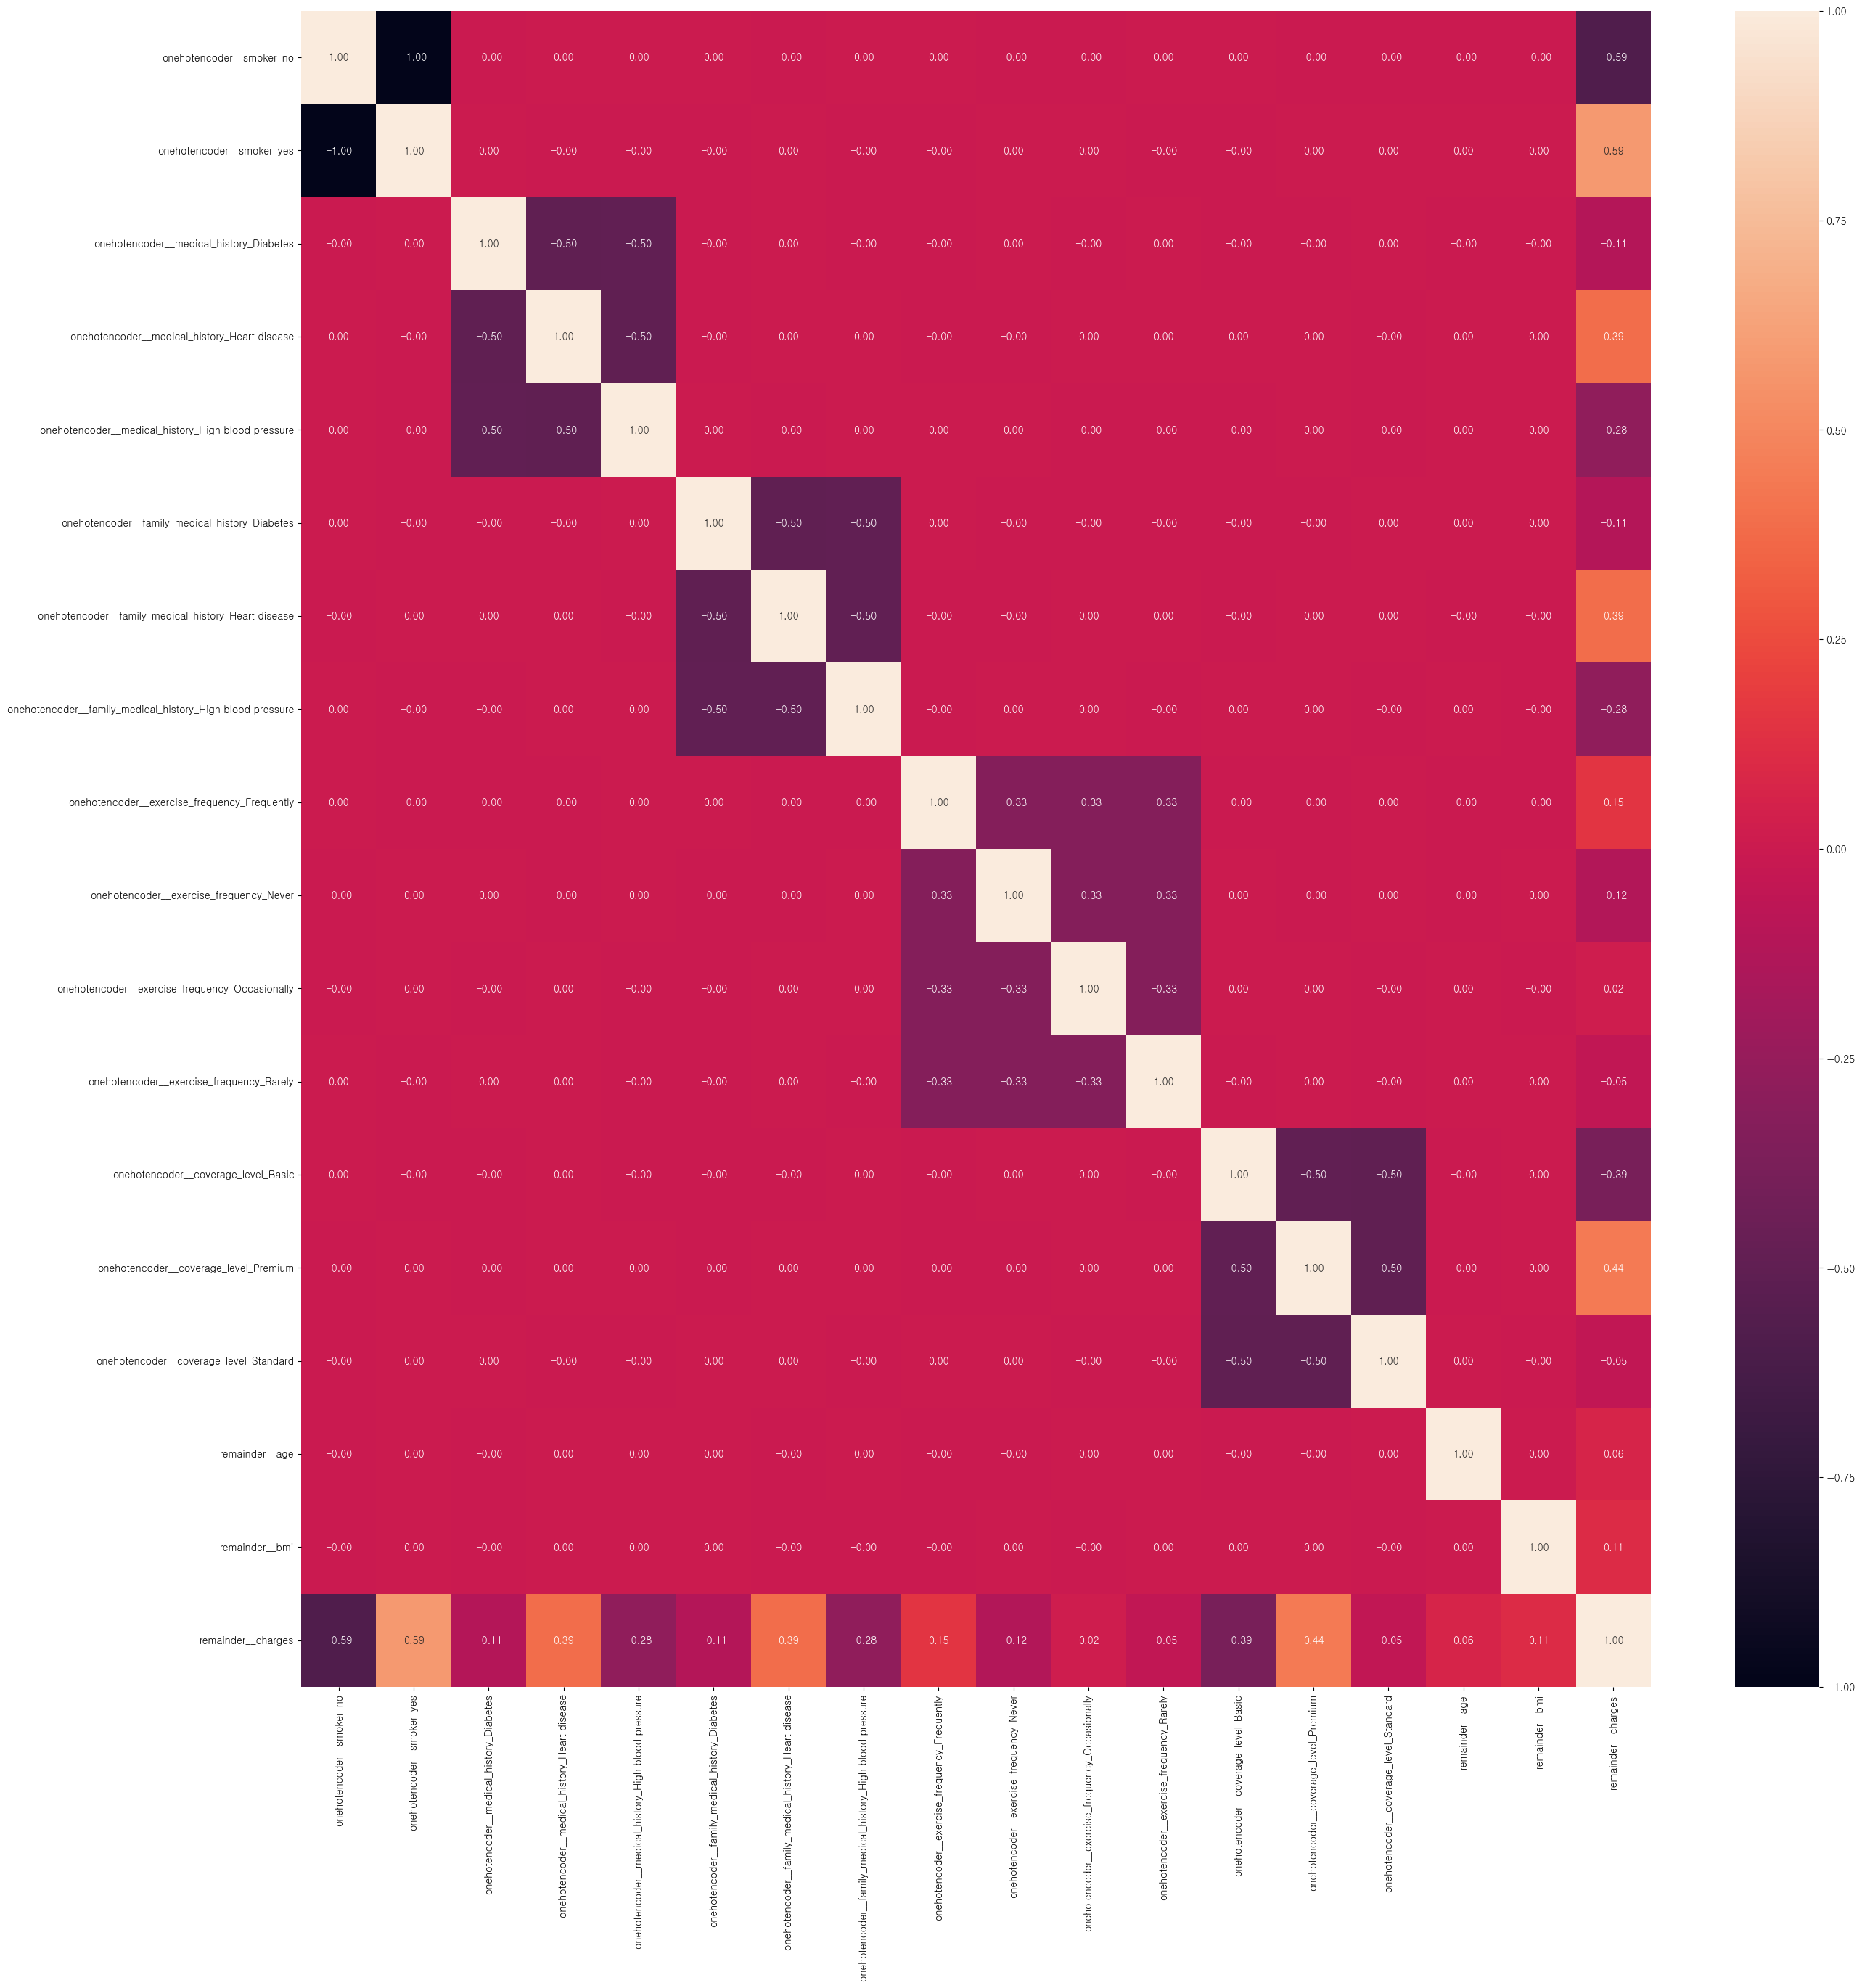

In [39]:
correlation_matrix = df.corr()

plt.figure(figsize = (30,30))
sns.heatmap(correlation_matrix,vmax=1,vmin=-1,annot=True,fmt=".2f")

> 그래프의 맨 아래쪽을 확인해보면   
흡연자인 경우 0.59, 보험 플랜이 premium인 경우 0.44, 심장병 이력이나 가족력이 있는 경우 0.39로 보험료와 높은 상관관계를 보이는 것을 알 수 있다.

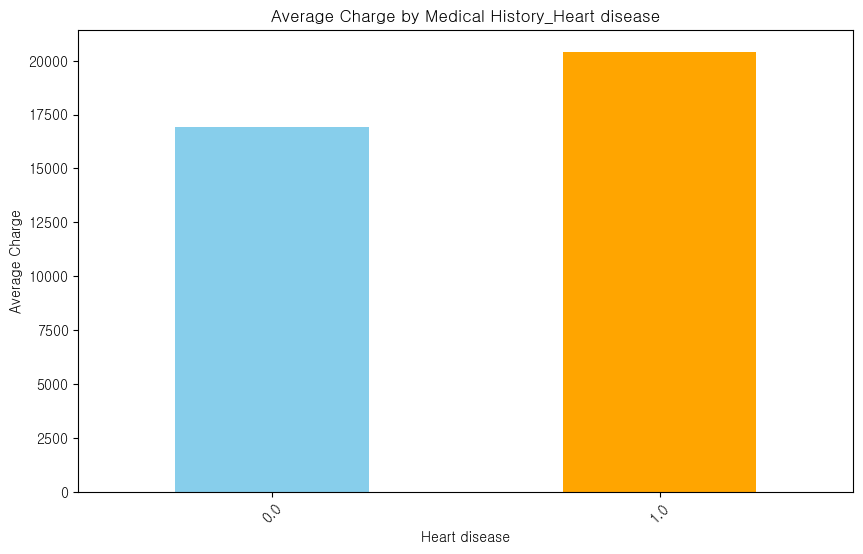

                                              onehotencoder__medical_history_Heart disease  \
onehotencoder__medical_history_Heart disease                                      1.000000   
remainder__charges                                                                0.385946   

                                              remainder__charges  
onehotencoder__medical_history_Heart disease            0.385946  
remainder__charges                                      1.000000  


In [40]:

# medical_history별 charge 평균 계산
grouped = df.groupby('onehotencoder__medical_history_Heart disease')['remainder__charges'].mean()

# 시각화
grouped.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'])
plt.title('Average Charge by Medical History_Heart disease')
plt.xlabel('Heart disease')
plt.ylabel('Average Charge')
plt.xticks(rotation=45)
plt.show()#상관계수 계산
correlation = df[['onehotencoder__medical_history_Heart disease', 'remainder__charges']].corr()

# 결과 출력
print(correlation)


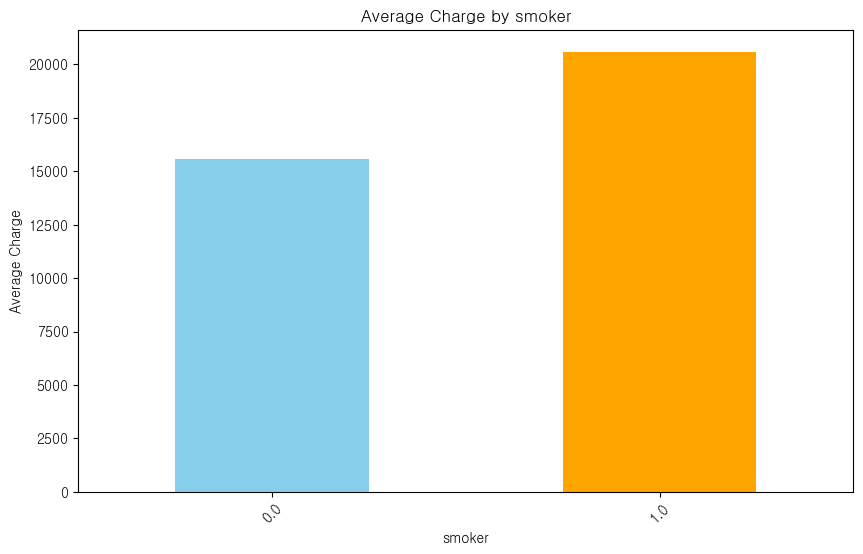

                           onehotencoder__smoker_yes  remainder__charges
onehotencoder__smoker_yes                   1.000000            0.585736
remainder__charges                          0.585736            1.000000


In [41]:
# medical_history별 charge 평균 계산
grouped = df.groupby('onehotencoder__smoker_yes')['remainder__charges'].mean()

# 시각화
grouped.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'])
plt.title('Average Charge by smoker')
plt.xlabel('smoker')
plt.ylabel('Average Charge')
plt.xticks(rotation=45)
plt.show()#상관계수 계산
correlation = df[['onehotencoder__smoker_yes', 'remainder__charges']].corr()

# 결과 출력
print(correlation)

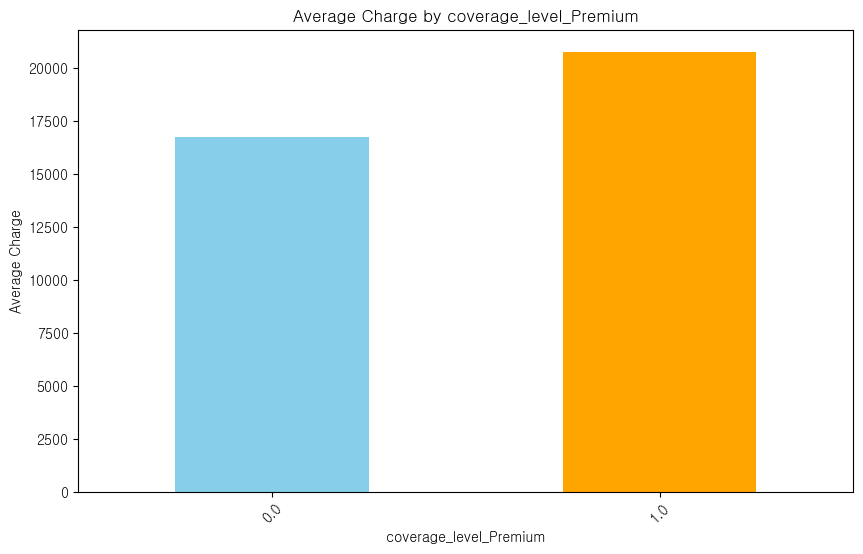

                                       onehotencoder__coverage_level_Premium  \
onehotencoder__coverage_level_Premium                               1.000000   
remainder__charges                                                  0.441602   

                                       remainder__charges  
onehotencoder__coverage_level_Premium            0.441602  
remainder__charges                               1.000000  


In [42]:
# medical_history별 charge 평균 계산
grouped = df.groupby('onehotencoder__coverage_level_Premium')['remainder__charges'].mean()

# 시각화
grouped.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'])
plt.title('Average Charge by coverage_level_Premium')
plt.xlabel('coverage_level_Premium')
plt.ylabel('Average Charge')
plt.xticks(rotation=45)
plt.show()#상관계수 계산
correlation = df[['onehotencoder__coverage_level_Premium', 'remainder__charges']].corr()

# 결과 출력
print(correlation)


> 상관관계분석 결과  
 1)흡연자 2)보험 플랜-premium 3)심장병 이력이 있는 경우 1에서 3번 순으로 상관관계가 높은 것을 확인할 수 있다. 

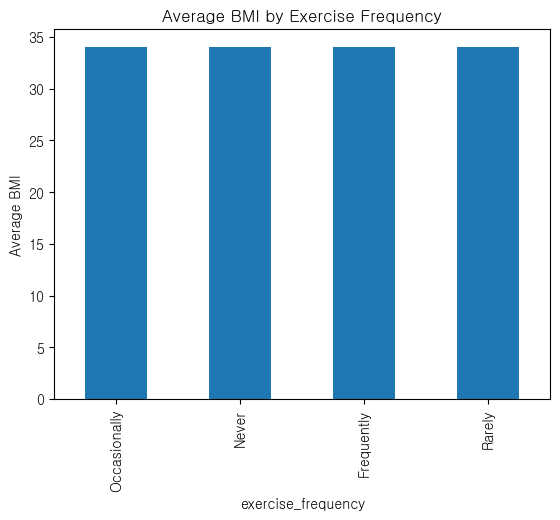

In [43]:
# 운동 빈도별 BMI 평균
exercise_bmi = data.groupby('exercise_frequency')['bmi'].mean().sort_values()

# 시각화
exercise_bmi.plot(kind='bar', title='Average BMI by Exercise Frequency')
plt.ylabel('Average BMI')
plt.show()


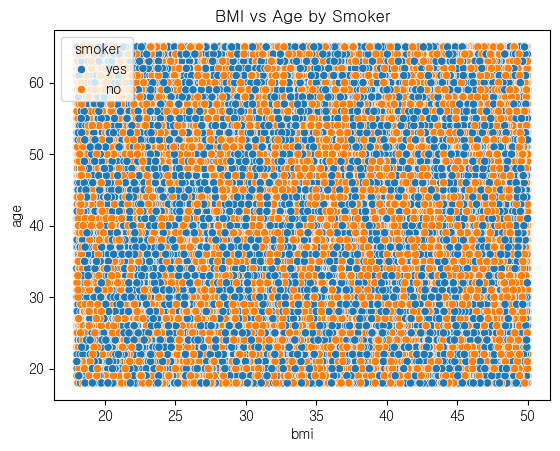

In [44]:
# BMI와 나이의 산점도
sns.scatterplot(x='bmi', y='age', hue='smoker', data=data)
plt.title('BMI vs Age by Smoker')
plt.show()

medical_history  Diabetes  Heart disease  High blood pressure
smoker                                                       
no               0.331515       0.333996             0.334489
yes              0.334054       0.333672             0.332274


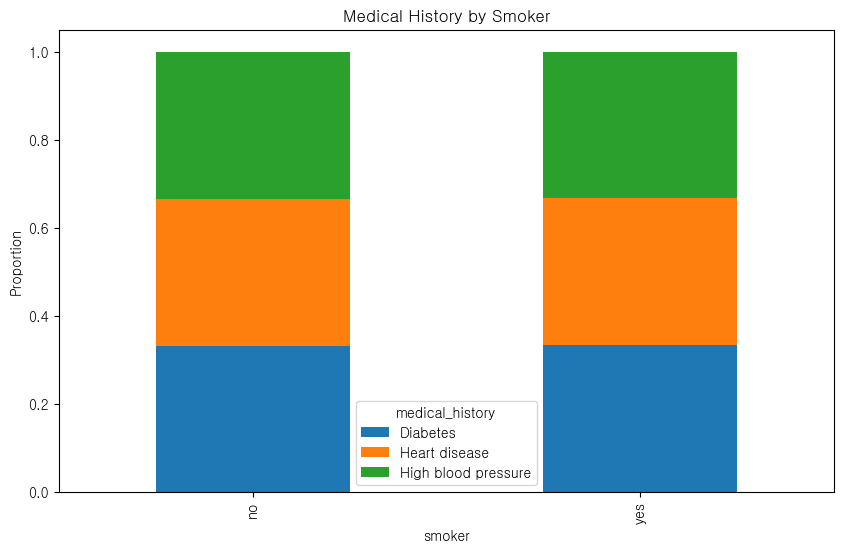

In [45]:
# 흡연 여부별 메디컬 히스토리 비율
smoker_history = data.groupby('smoker')['medical_history'].value_counts(normalize=True).unstack()
print(smoker_history)

# 시각화
smoker_history.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Medical History by Smoker')
plt.ylabel('Proportion')
plt.show()

# 랏쏘 회귀귀

In [47]:
# 데이터 분리
# 독립 변수(X)와 종속 변수(y) 분리
# 데이터를 학습용(train)과 테스트용(test)으로 나누기
from sklearn.model_selection import train_test_split

X = df.drop(columns=['remainder__charges'])  # 독립 변수
y = df['remainder__charges']  # 종속 변수

In [48]:
# 학습용/테스트용 데이터 분할 (70% 학습, 30% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [49]:
# 라쏘 회귀 하이퍼파라미터 튜닝
param_grid_lasso = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}
lasso = Lasso(random_state=42, max_iter=10000)
grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_lasso.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(max_iter=10000, random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [50]:
# 최적의 모델 선택
best_lasso = grid_search_lasso.best_estimator_

In [51]:
# 테스트 데이터 예측
y_pred_lasso = best_lasso.predict(X_test)

In [52]:
# 평가
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print("Lasso Regression:")
print(f"MSE: {mse_lasso}")
print(f"R²: {r2_lasso}")

Lasso Regression:
MSE: 1165835.521128346
R²: 0.936066752918417


# 보완

In [53]:
# 데이터 정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
# 보완된 alpha 범위로 하이퍼파라미터 튜닝
param_grid_lasso = {
    'alpha': [0.001, 0.01, 0.1, 1, 10]  # alpha 범위를 세분화
}

In [55]:
lasso = Lasso(random_state=42, max_iter=10000)

In [56]:
grid_search_lasso = GridSearchCV(
    estimator=lasso, param_grid=param_grid_lasso, cv=5,
    scoring='neg_mean_squared_error', n_jobs=-1
)

In [57]:
# 정규화된 데이터로 학습
grid_search_lasso.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Lasso(max_iter=10000, random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10]},
             scoring='neg_mean_squared_error')

In [58]:
# 최적의 Lasso 모델 선택
best_lasso = grid_search_lasso.best_estimator_

In [59]:
# 중요 변수 확인 (coef_)
important_features = pd.Series(best_lasso.coef_, index=X.columns)
print("Feature Importance:")
print(important_features)

Feature Importance:
onehotencoder__smoker_no                                    -2.499319e+03
onehotencoder__smoker_yes                                    1.651520e-11
onehotencoder__medical_history_Diabetes                     -1.526339e+02
onehotencoder__medical_history_Heart disease                 1.260843e+03
onehotencoder__medical_history_High blood pressure          -6.215526e+02
onehotencoder__family_medical_history_Diabetes              -1.523998e+02
onehotencoder__family_medical_history_Heart disease          1.263672e+03
onehotencoder__family_medical_history_High blood pressure   -6.225611e+02
onehotencoder__exercise_frequency_Frequently                 6.111879e+02
onehotencoder__exercise_frequency_Never                     -2.517224e+02
onehotencoder__exercise_frequency_Occasionally               1.792242e+02
onehotencoder__exercise_frequency_Rarely                    -3.551461e+01
onehotencoder__coverage_level_Basic                         -1.408473e+03
onehotencoder__cov

In [60]:
# 테스트 데이터에 대한 예측
y_pred_lasso = best_lasso.predict(X_test_scaled)

In [61]:
# 평가
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("Lasso Regression (After Improvements):")
print(f"MSE: {mse_lasso}")
print(f"R²: {r2_lasso}")

Lasso Regression (After Improvements):
MSE: 1165835.1223623457
R²: 0.9360667747863433
